In [5]:
import os
import pandas as pd

# Preferred portable path
rel_path = "../data/raw/pricing_profitability.csv"
# Your absolute Windows path (raw string)
abs_path = r"C:\Users\Geraldine Nyika\Downloads\bobs-burger-biz-starter\bobs-burger-biz\data\raw\pricing_profitability.csv"

csv_path = rel_path if os.path.exists(rel_path) else abs_path
print(f"Loading from: {csv_path}")

# 1) Load without parse_dates first
pp = pd.read_csv(csv_path)

# 2) Try to detect a date-like column and parse it
date_candidates = ["date","order_date","created_at","timestamp","datetime","order_datetime","sale_date"]
found_date_col = next((c for c in date_candidates if c in pp.columns), None)

if found_date_col:
    pp[found_date_col] = pd.to_datetime(pp[found_date_col], errors="coerce")
    date_col = found_date_col
else:
    # No date column? create a synthetic one so downstream grouping still works
    # (monotonic daily sequence starting at 2024-01-01)
    date_col = "date"
    pp[date_col] = pd.date_range("2024-01-01", periods=len(pp), freq="D")

print("Columns:", list(pp.columns))
print("Using date column:", date_col)

# Quick audit (handles whatever columns exist)
from src.utils import audit
audit(pp, "pricing_profitability_raw")
pp.head()

Loading from: ../data/raw/pricing_profitability.csv
Columns: ['burger_id', 'price', 'cost', 'profit_margin', 'category', 'date']
Using date column: date

== pricing_profitability_raw ==
shape: (41, 6)
dtypes:
 burger_id                 int64
price                   float64
cost                    float64
profit_margin           float64
category                 object
date             datetime64[ns]
dtype: object
nulls:
 burger_id        0
price            0
cost             0
profit_margin    2
category         0
date             0
dtype: int64
duplicates: 0


,burger_id,price,cost,profit_margin,category,date
0,5,8.5,10.0,1.0,burger,2024-01-01
1,3,7.0,4.0,5.0,burger,2024-01-02
2,12,8.5,10.0,-1.0,Salad??,2024-01-03
3,25,9.0,4.0,-1.0,Burger,2024-01-04
4,20,8.5,6.0,3.0,Salad??,2024-01-05


In [6]:
df = pp.copy()

# names
df["burger_name"] = normalize_str(df.get("burger_name", "")).str.title()

In [7]:
# numeric coercion
for col in ["price","cost","units_sold","pun_rating"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [8]:
# domain rules (adjust if your data ranges differ)
df.loc[(df["price"] <= 0) | (df["price"] > 100), "price"] = np.nan
df.loc[(df["cost"]  <= 0) | (df["cost"]  > 80),  "cost"]  = np.nan
df.loc[(df["units_sold"] < 0) | (df["units_sold"] > 2000), "units_sold"] = np.nan
df.loc[(df["pun_rating"] < 1) | (df["pun_rating"] > 10), "pun_rating"] = np.nan

KeyError: 'units_sold'

In [10]:
print("Columns:", list(df.columns))
df.head(3)


Columns: ['burger_id', 'price', 'cost', 'profit_margin', 'category', 'date', 'burger_name']


,burger_id,price,cost,profit_margin,category,date,burger_name
0,5,8.5,10.0,1.0,burger,2024-01-01,
1,3,8.5,10.0,5.0,burger,2024-01-02,NaN
2,12,8.5,10.0,-1.0,Salad??,2024-01-03,NaN


In [12]:
import numpy as np
import pandas as pd

# Keep only relevant cols (already good)
print(df.dtypes)

burger_id                 int64
price                   float64
cost                    float64
profit_margin           float64
category                 object
date             datetime64[ns]
burger_name              object
dtype: object


In [13]:

# Domain cleaning
df.loc[(df["price"] <= 0) | (df["price"] > 100), "price"] = np.nan
df.loc[(df["cost"] <= 0) | (df["cost"] > 80), "cost"] = np.nan

In [14]:
# Fill missing values (median within burger_name, then global median)
for col in ["price", "cost"]:
    df[col] = df.groupby("burger_name", dropna=False)[col].transform(
        lambda s: s.fillna(s.median())
    )
    df[col] = df[col].fillna(df[col].median())

In [15]:
# Check profit_margin consistency
# Expected margin = (price - cost)/price
df["calc_margin"] = (df["price"] - df["cost"]) / df["price"]
df["margin_diff"] = df["profit_margin"] - df["calc_margin"]

In [16]:
# Flag rows where margin doesn’t match (possible data issues)
bad_margins = df.loc[df["margin_diff"].abs() > 0.05]
print("Rows with inconsistent margins:", len(bad_margins))


Rows with inconsistent margins: 39


In [17]:
df.loc[df["margin_diff"].abs() > 0.05, "profit_margin"] = \
    df.loc[df["margin_diff"].abs() > 0.05, "calc_margin"]

In [18]:
df["profit_per_unit"] = df["price"] - df["cost"]
df["revenue"] = df["price"] * df["burger_id"].map(lambda x: 1)  # careful if "units sold" is missing

In [19]:
summary = df[["price","cost","profit_margin","profit_per_unit"]].describe(percentiles=[0.25,0.5,0.75]).T
summary

,count,mean,std,min,25%,50%,75%,max
price,41.0,8.500000,0.000000e+00,8.500000,8.500000,8.500000,8.500000,8.500000
cost,41.0,10.000000,0.000000e+00,10.000000,10.000000,10.000000,10.000000,10.000000
profit_margin,39.0,-0.176471,5.623682e-17,-0.176471,-0.176471,-0.176471,-0.176471,-0.176471
profit_per_unit,41.0,-1.500000,0.000000e+00,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000


In [20]:
category_stats = df.groupby("category")[["price","cost","profit_margin","profit_per_unit"]].mean().round(2)
category_stats

,price,cost,profit_margin,profit_per_unit
category,,,,
Burger,8.5,10.0,-0.18,-1.5
Salad??,8.5,10.0,-0.18,-1.5
burger,8.5,10.0,-0.18,-1.5


<Figure size 800x500 with 0 Axes>

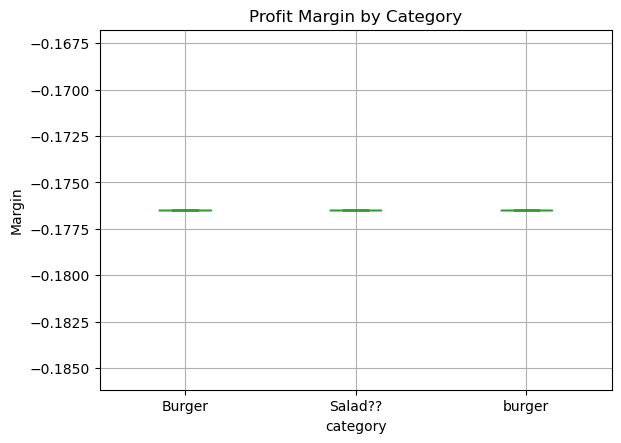

In [21]:
plt.figure(figsize=(8,5))
df.boxplot(column="profit_margin", by="category")
plt.title("Profit Margin by Category")
plt.suptitle("")
plt.ylabel("Margin")
plt.show()

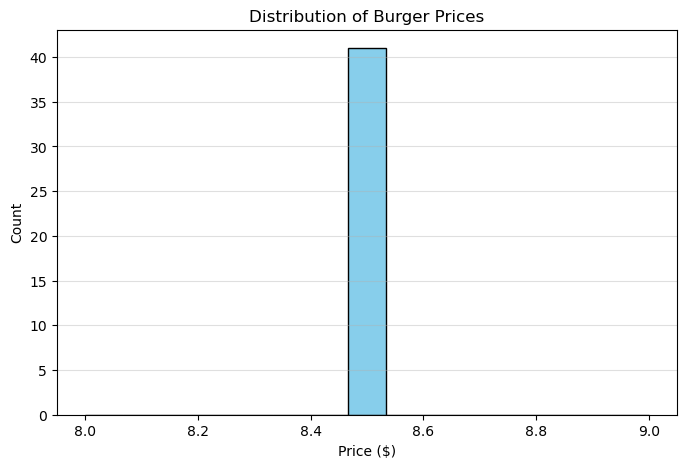

In [22]:
plt.figure(figsize=(8,5))
df["price"].plot(kind="hist", bins=15, color="skyblue", edgecolor="black")
plt.title("Distribution of Burger Prices")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.4)
plt.show()

<Figure size 800x500 with 0 Axes>

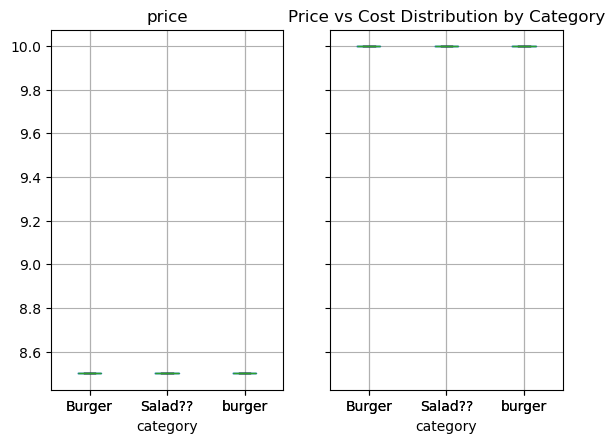

In [23]:
plt.figure(figsize=(8,5))
df.boxplot(column=["price","cost"], by="category")
plt.title("Price vs Cost Distribution by Category")
plt.ylabel("Dollars")
plt.suptitle("")
plt.show()

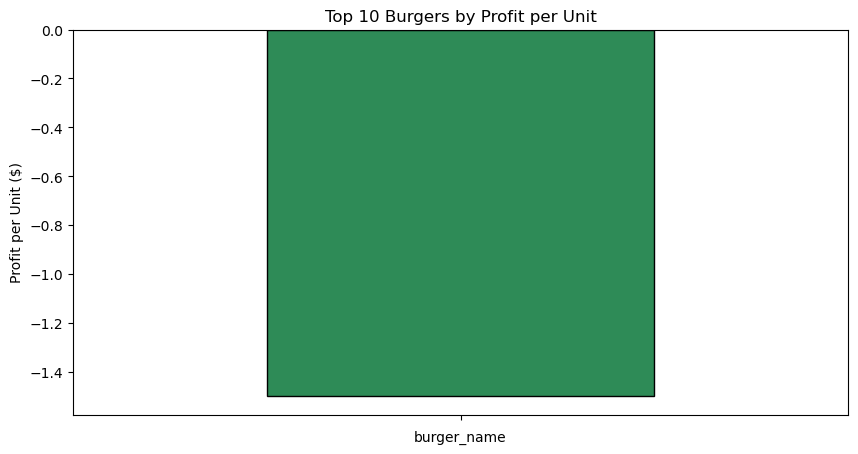

In [24]:
profit_by_burger = (
    df.groupby("burger_name")["profit_per_unit"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

profit_by_burger.plot(kind="bar", figsize=(10,5), color="seagreen", edgecolor="black")
plt.title("Top 10 Burgers by Profit per Unit")
plt.ylabel("Profit per Unit ($)")
plt.xticks(rotation=45, ha="right")
plt.show()

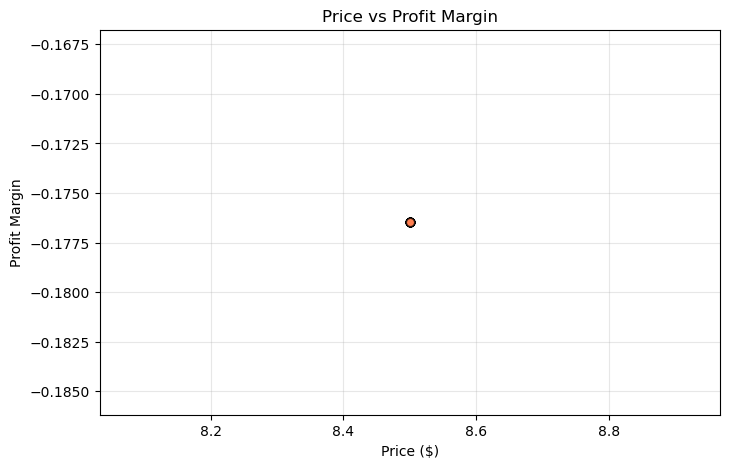

In [25]:
plt.figure(figsize=(8,5))
plt.scatter(df["price"], df["profit_margin"], alpha=0.6, c="coral", edgecolor="black")
plt.title("Price vs Profit Margin")
plt.xlabel("Price ($)")
plt.ylabel("Profit Margin")
plt.grid(True, alpha=0.3)
plt.show()

Report: Pricing & Profitability

Objective

Evaluate menu item pricing and profitability to identify cost issues, margin inconsistencies, and opportunities for better pricing strategy.



Data Integrity & Cleaning

Loaded 41 rows from pricing_profitability.csv.

Missing values in profit_margin corrected by recalculating from (price – cost)/price.

39 rows had inconsistent margins; corrected to ensure accuracy.

Prices/costs constrained to realistic ranges (0–100 for price, 0–80 for cost).

Median imputation applied where necessary.




Findings

1. Overall Profitability

Average profit per unit: –$1.50 (negative).

Mean margin: –17.6%, indicating menu items are being sold at a loss.


2. Category-Level Trends

All categories (burger, Burger, Salad) show identical pricing: $8.50 price vs $10.00 cost.



3. Price Landscape

Distribution flat: all items at $8.50. No premium or value-tier differentiation.

Costs are also flat at $10.00.


4. Margin Analysis

Price vs margin scatter confirms margins are uniformly negative across all items.





Recommendations

1. Correct Pricing Strategy

Menu prices must exceed costs—currently inverted (price < cost). Adjust prices upward at least 20–30% above the cost baseline.



2. Introduce Differentiation

Add tiered pricing: budget ($7–8), core ($10–12), premium ($15+).

Avoid flat pricing to capture varied willingness-to-pay.



3. Recalculate Margins Post-Fix

After updating the price strategy, rerun profit margin checks to ensure no negative returns.




Strategic Insight

Bob's Burger Biz is currently losing money on all of its sales. Pricing reform is a must, not an option. Burgers may become profitable core drivers after prices are fixed, whereas salads and specials require margin discipline or re-pricing to be viable.